# Confidence In the Press

One of the notebooks in the [Political Alignment Case Study](https://allendowney.github.io/PoliticalAlignmentCaseStudy/) is a template for exploring relationships between political alignment (liberal or conservative) and other beliefs and attitudes.
In this notebook, we'll use that template to look at the ways confidence in the press has changed over the last 50 years in the U.S.

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/PoliticalAlignmentCaseStudy/blob/v1/examples/confidence.ipynb).

## Data and Libraries

This section loads an excerpt of data from the [General Social Survey]() and the libraries we'll use to analyze it.

In [1]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)

download("https://github.com/AllenDowney/PoliticalAlignmentCaseStudy/raw/v1/utils.py")

The following cell installs the `empiricaldist` library if necessary.

In [2]:
try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

If everything we need is installed, the following cell should run without error.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from empiricaldist import Pmf

The following cells import utility functions from previous chapters.

In [4]:
from utils import values, decorate, make_lowess, plot_series_lowess, plot_columns_lowess

The following cell downloads the data file.

In [5]:
download(
    "https://github.com/AllenDowney/PoliticalAlignmentCaseStudy/raw/v1/gss_pacs_resampled.hdf"
)

The data file contains three resamplings of the original dataset.
We'll start with the first.

In [6]:
datafile = "gss_pacs_resampled.hdf"
gss = pd.read_hdf(datafile, "gss0")
gss.shape

(72390, 207)

## Changes in Confidence

The General Social Survey includes several questions about a confidence in various institutions.
Here are the names of the variables that contain the responses.

In [7]:
' '.join(column for column in gss.columns if 'con' in column)

'conarmy conbus conclerg coneduc confed confinan coninc conjudge conlabor conlegis conmedic conpress conrinc consci contv'

Here's how this section of the survey is introduced.

> I am going to name some institutions in this country. As far as the people running these institutions are concerned, would you say you have a great deal of confidence, only some confidence, or hardly any confidence at all in them?

The variable we'll explore is `conpress`, which is about "the press".

In [8]:
varname = "conpress"
column = gss[varname]
column.tail()

72385    2.0
72386    3.0
72387    3.0
72388    2.0
72389    2.0
Name: conpress, dtype: float64

As we'll see, response to this question have changed substantiall over the last few decades.

## Responses

Here's the distribution of responses:

In [9]:
column.value_counts(dropna=False).sort_index()

1.0     6968
2.0    24403
3.0    16769
NaN    24250
Name: conpress, dtype: int64

The special value `NaN` indicates that the respondent was not asked the question, declined to answer, or said they didn't know.

The following cell shows the numerical values and the text of the responses they stand for.

In [10]:
responses = [1, 2, 3]

labels = [
    "A great deal",
    "Only some",
    "Hardly any",
]

Here's what the distribution looks like.
`plt.xticks` puts labels on the $x$-axis.

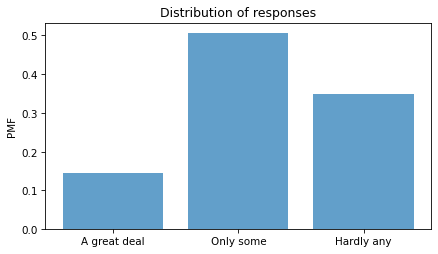

In [11]:
pmf = Pmf.from_seq(column)
pmf.bar(alpha=0.7)

decorate(ylabel="PMF", title="Distribution of responses")
plt.xticks(responses, labels);

About had of the respondents have "only some" confidence in the press -- but we should not make too much of this result because it combines different numbers of respondents interviewed at different times.

## Responses over time

If we make a cross tabulation of `year` and the variable of interest, we get the distribution of responses over time.

In [12]:
xtab = pd.crosstab(gss["year"], column, normalize="index") * 100
xtab.head()

conpress        1.0        2.0        3.0
year                                     
1973      22.696477  62.398374  14.905149
1974      24.846835  55.752212  19.400953
1975      23.928077  58.160443  17.911480
1976      29.323308  53.588517  17.088175
1977      24.484365  59.148370  16.367265

Now we can plot the results.

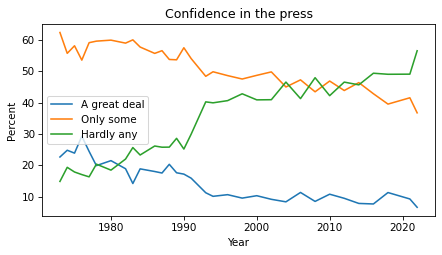

In [13]:
for response, label in zip(responses, labels):
    xtab[response].plot(label=label)

decorate(xlabel="Year", ylabel="Percent", title="Confidence in the press")

The percentages of "A great deal" and "Only some" have been declining since the 1970s.
The percentage of "Hardly any" has increased substantially.

## Political alignment

To explore the relationship between these responses and political alignment, we'll recode political alignment into three groups:

In [14]:
d_polviews = {
    1: "Liberal",
    2: "Liberal",
    3: "Liberal",
    4: "Moderate",
    5: "Conservative",
    6: "Conservative",
    7: "Conservative",
}

Now we can use `replace` and store the result as a new column in the `DataFrame`.

In [15]:
gss["polviews3"] = gss["polviews"].replace(d_polviews)

With this scale, there are roughly the same number of people in each group.

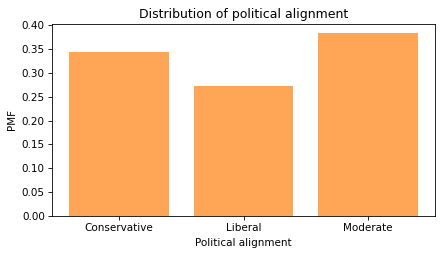

In [16]:
pmf = Pmf.from_seq(gss["polviews3"])
pmf.bar(color="C1", alpha=0.7)

decorate(
    xlabel="Political alignment",
    ylabel="PMF",
    title="Distribution of political alignment",
)

## Group by political alignment

Now we can use `groupby` to group the respondents by political alignment.

In [17]:
by_polviews = gss.groupby("polviews3")

Here's a dictionary that maps from each group to a color.

In [18]:
muted = sns.color_palette("muted", 5)
color_map = {"Conservative": muted[3], "Moderate": muted[4], "Liberal": muted[0]}

Now we can make a PMF of responses for each group.

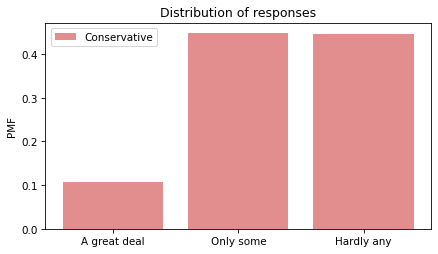

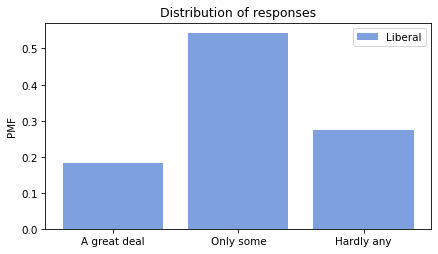

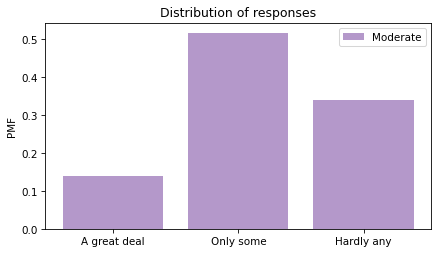

In [19]:
for name, group in by_polviews:
    plt.figure()
    pmf = Pmf.from_seq(group[varname])
    pmf.bar(label=name, color=color_map[name], alpha=0.7)

    decorate(ylabel="PMF", title="Distribution of responses")
    plt.xticks(responses, labels)

Looking at the "Hardly any" response, it looks like conservatives have the least confidence in the press.

## Recode

To quantify changes in these responses over time, one option is to put them on a numerical scale and compute the mean.
Another option is to compute the percentage who choose a particular response or set of responses.
Since the changes have been most notable in the "Hardly any" response, that's what we'll track.
We'll use `replace` to recode the values so "Hardly any" is `1` and all other responses are `0`.

In [20]:
d_recode = {1: 0, 2: 0, 3: 1}

gss["recoded"] = column.replace(d_recode)
gss["recoded"].name = varname

We can use `value_counts` to confirm that it worked.

In [21]:
gss["recoded"].value_counts(dropna=False)

0.0    31371
NaN    24250
1.0    16769
Name: conpress, dtype: int64

Now if we compute the mean, we can interpret it as the fraction of respondents who report "hardly any" confidence in the press.
Multiplying by `100` makes it a percentage.

In [22]:
gss["recoded"].mean() * 100

34.833818030743664

Note that the `Series` method `mean` drops `NaN` values before computing the mean.
The NumPy function `mean` does not.

## Average by group

We can use `by_polviews` to compute the mean of the recoded variable in each group, and multiply by `100` to get a percentage.

In [23]:
means = by_polviews["recoded"].mean() * 100
means

polviews3
Conservative    44.410101
Liberal         27.293806
Moderate        34.113831
Name: conpress, dtype: float64

By default, the group names are in alphabetical order.
To get the values in a particular order, we can use the group names as an index:

In [24]:
groups = ["Conservative", "Moderate", "Liberal"]
means[groups]

polviews3
Conservative    44.410101
Moderate        34.113831
Liberal         27.293806
Name: conpress, dtype: float64

Now we can make a bar plot with color-coded bars:

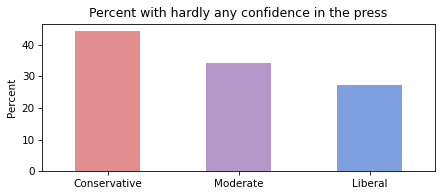

In [25]:
title = "Percent with hardly any confidence in the press"
colors = color_map.values()
means[groups].plot(kind="bar", color=colors, alpha=0.7, label="")

decorate(
    xlabel="",
    ylabel="Percent",
    title=title,
)

plt.xticks(rotation=0);

Conservatives have less confidence in the press than liberals, and moderates are somewhere in the middle.

But again, these results are an average over the interval of the survey, so you should not interpret them as a current condition.

## Time series

We can use `groupby` to group responses by year.

In [26]:
by_year = gss.groupby("year")

From the result we can select the recoded variable and compute the percentage that responded "Hardly any".

In [27]:
time_series = by_year["recoded"].mean() * 100

And we can plot the results with the data points themselves as circles and a local regression model as a line.

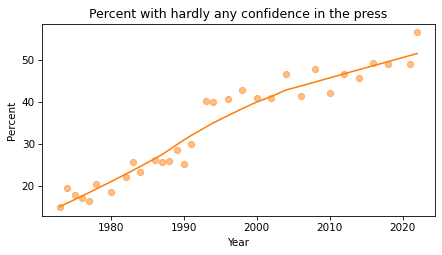

In [28]:
plot_series_lowess(time_series, "C1", label='')

decorate(
    xlabel="Year",
    ylabel="Percent",
    title=title
)

The fraction of respondents with "Hardly any" confidence in the press has increased consistently over the duration of the survey.

## Time series by group

So far, we have grouped by `polviews3` and computed the mean of the variable of interest in each group.
Then we grouped by `year` and computed the mean for each year.
Now we'll use `pivot_table` to compute the mean in each group for each year.

In [29]:
table = gss.pivot_table(
    values="recoded", index="year", columns="polviews3", aggfunc="mean"
) * 100

In [30]:
table.head()

polviews3  Conservative    Liberal   Moderate
year                                         
1974          22.482436  17.312073  16.604478
1975          22.335025  10.884354  17.481203
1976          19.495413  17.794486  14.901257
1977          22.398190  13.207547  14.650767
1978          27.176221  18.048780  16.819013

The result is a table that has years running down the rows and political alignment running across the columns.
Each entry in the table is the mean of the variable of interest for a given group in a given year.

## Plotting the results

Now let's see the results.

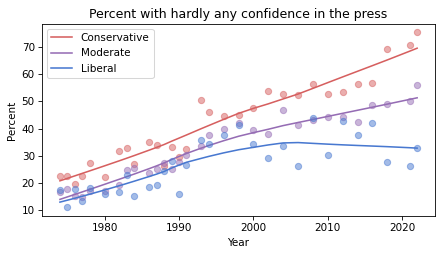

In [31]:
for group in groups:
    series = table[group]
    plot_series_lowess(series, color_map[group])
    
decorate(
    xlabel="Year",
    ylabel="Percent",
    title="Percent with hardly any confidence in the press",
)

Confidence in the press has decreased in all three groups, but among liberals it might have leveled off or even reversed.

## Resampling

The figures we've generated so far in this notebook are based on a single resampling of the GSS data.  Some of the features we see in these figures might be due to random sampling rather than actual changes in the world.
By generating the same figures with different resampled datasets, we can get a sense of how much variation there is due to random sampling.
To make that easier, the following function contains the code from the previous analysis all in one place.

In [32]:
def plot_by_polviews(gss, varname):
    """Plot mean response by polviews and year.

    gss: DataFrame
    varname: string column name
    """
    gss["polviews3"] = gss["polviews"].replace(d_polviews)

    column = gss[varname]
    gss["recoded"] = column.replace(d_recode)

    table = gss.pivot_table(
        values="recoded", index="year", columns="polviews3", aggfunc="mean"
    ) * 100

    for group in groups:
        series = table[group]
        plot_series_lowess(series, color_map[group])

    decorate(
        xlabel="Year",
        ylabel="Percent",
        title=title,
    )

Now we can loop through the three resampled datasets and generate a figure for each one.

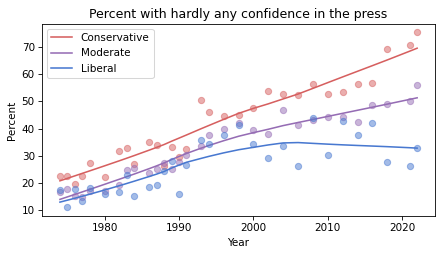

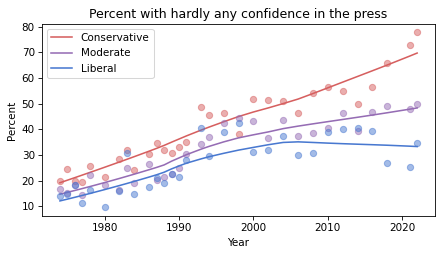

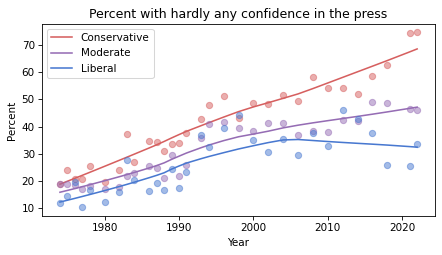

In [33]:
datafile = "gss_pacs_resampled.hdf"

for key in ["gss0", "gss1", "gss2"]:
    df = pd.read_hdf(datafile, key)

    plt.figure()
    plot_by_polviews(df, varname)

If you see an effect that is consistent in all three figures, it is less likely to be due to random sampling.
If it varies from one resampling to the next, you should probably not take it too seriously.

Based on these results, it seems likely that confidence in the press is continuing to decrease among conservatives and moderates, but not liberals -- with the result that polarization on this issue has increased since the 1990s.

Political Alignment Case Study

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)